## Install YOLO11 via Ultralytics

In [1]:
# autoreload makes sure all modules will be reimported once this cell is executed
# %autoreload 2: Reloads all modules (except those excluded by %aimport) before executing user code
%load_ext autoreload
%autoreload 2
    
import os

# Define home variable to make managing datasets, images and models easier
HOME = os.getcwd()
print(HOME)

/workspace/receipt2json


In [2]:
# Import ultralytics
#%pip install ultralytics roboflow 
import ultralytics

ultralytics.checks()

Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
Setup complete ✅ (64 CPUs, 125.8 GB RAM, 12.1/32.0 GB disk)


In [3]:
#!mkdir {HOME}/datasets
#%cd {HOME}/datasets

from roboflow import Roboflow
DATASET = f'{HOME}/datasets/receipt-instance-segmentation-2'



## Fine-tune YOLO11 on custom receipt dataset from roboflow

In [5]:
%cd {HOME}

!yolo task=segment mode=train model=yolo11s-seg.pt data={dataset.location}/data.yaml epochs=35 imgsz=640 plots=True

/workspace
100%|███████████████████████████████████████| 19.7M/19.7M [00:00<00:00, 110MB/s]
Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=/workspace/datasets/receipt-instance-segmentation-2/data.yaml, epochs=35, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_

### Evaluate Training


In [4]:
!nvidia-smi --query-gpu=memory.free --format=csv

memory.free [MiB]
11157 MiB


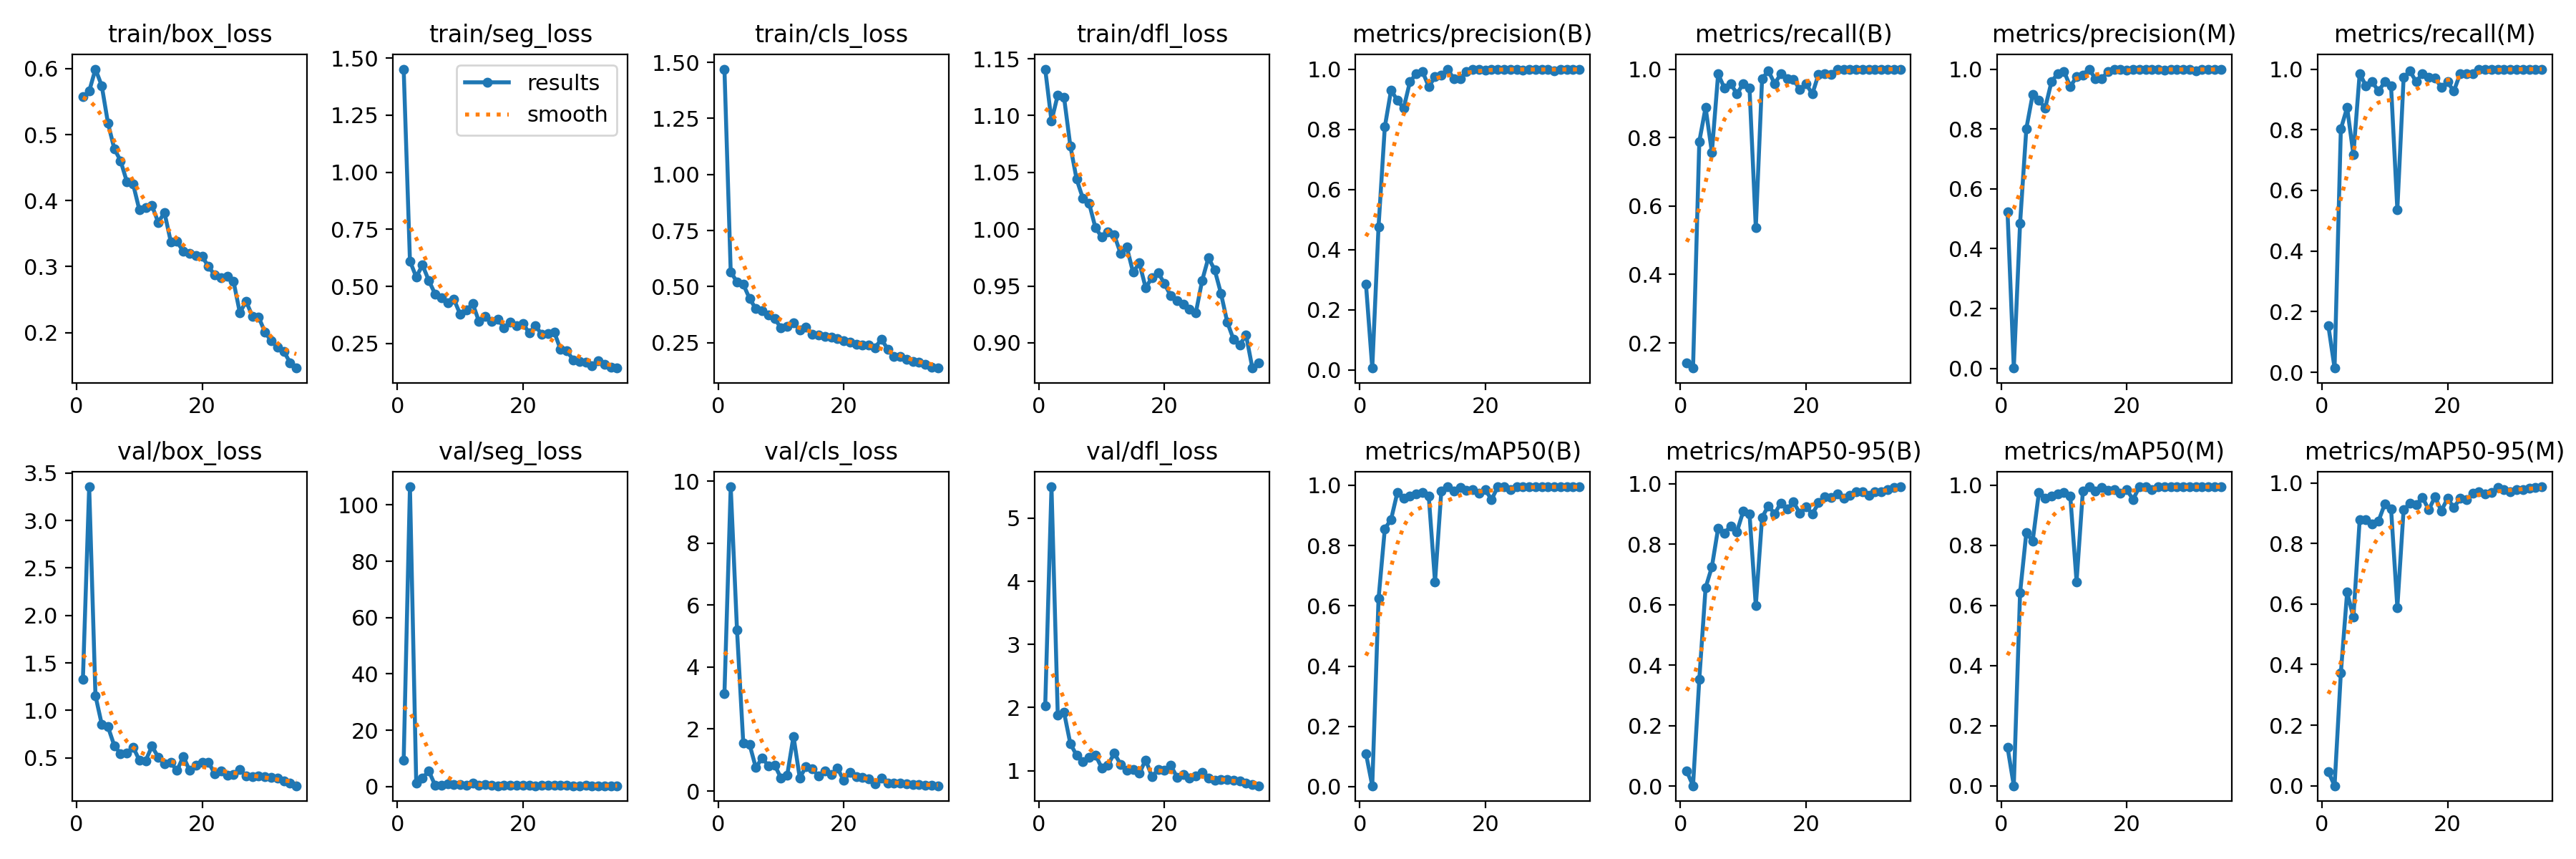

In [6]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/results.png', width=600)

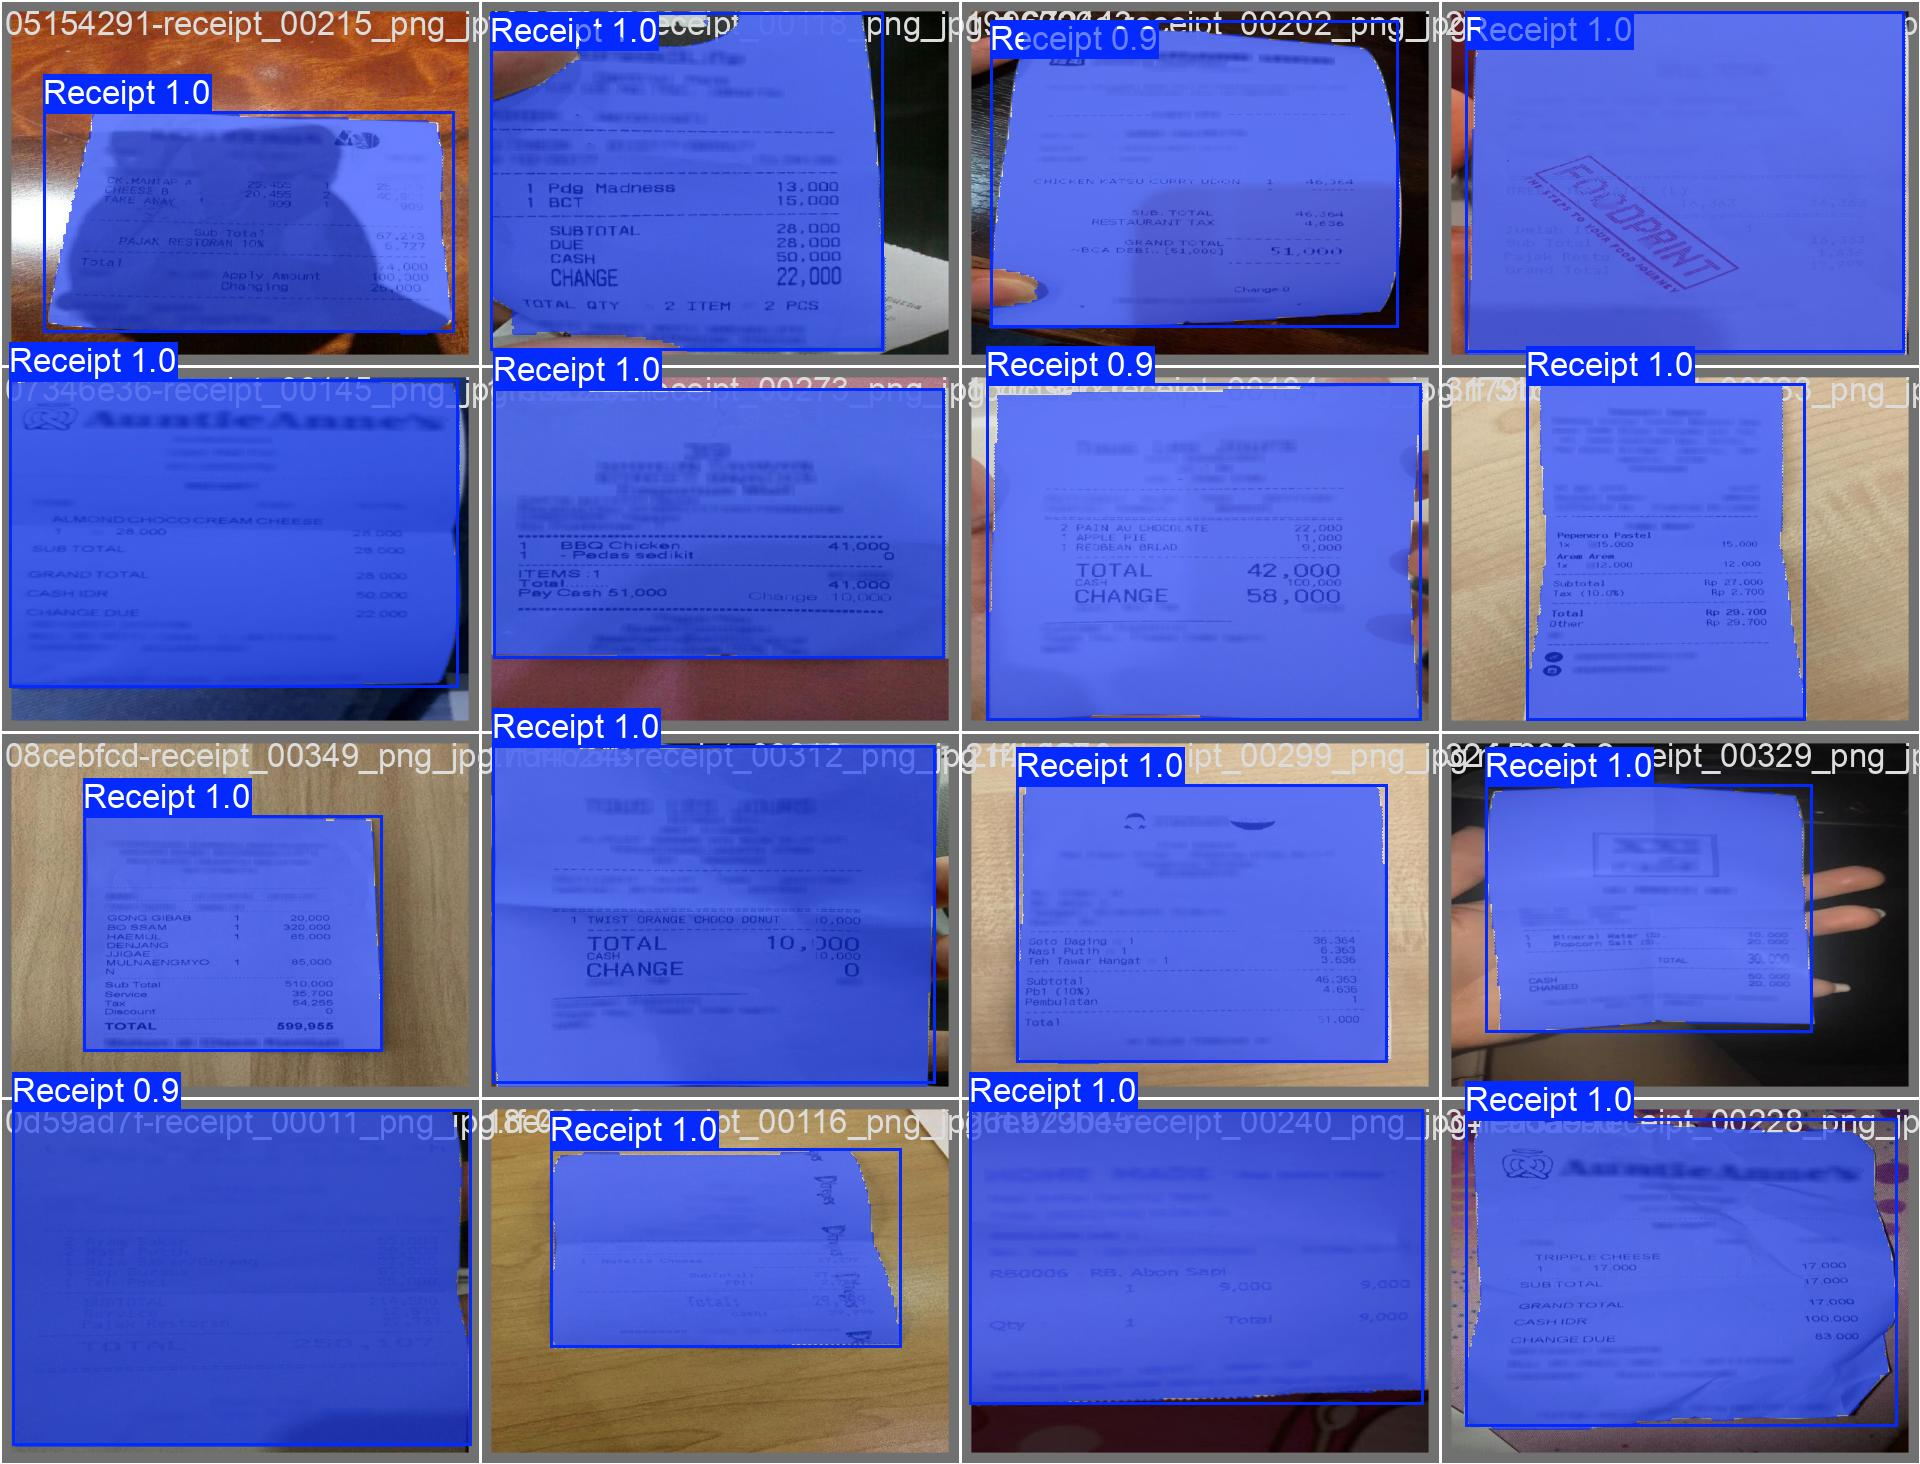

In [8]:
IPyImage(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=600)

In [9]:
!yolo task=segment mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11s-seg summary (fused): 113 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs
val: Scanning /workspace/datasets/receipt-instance-segmentation-2/valid/labels.c
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         71         71      0.999          1      0.995      0.989      0.999          1      0.995      0.987
Speed: 2.9ms preprocess, 9.3ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/val
💡 Learn more at https://docs.ultralytics.com/modes/val


### Inference with custom model

In [8]:
!yolo task=segment mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 source={DATASET}/test/images save=True

Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11s-seg summary (fused): 113 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs

image 1/35 /workspace/receipt2json/datasets/receipt-instance-segmentation-2/test/images/07151de1-receipt_00255_png_jpg.rf.43f1c5ed3c4200977f31d18455819aa9.jpg: 480x640 1 Receipt, 79.5ms
image 2/35 /workspace/receipt2json/datasets/receipt-instance-segmentation-2/test/images/12514370-receipt_00207_png_jpg.rf.ffc37f218510a99e596a0995cae08421.jpg: 480x640 1 Receipt, 14.5ms
image 3/35 /workspace/receipt2json/datasets/receipt-instance-segmentation-2/test/images/155fc19f-receipt_00061_png_jpg.rf.df6dd382300ddc0a90dd0c821c604c37.jpg: 480x640 1 Receipt, 14.7ms
image 4/35 /workspace/receipt2json/datasets/receipt-instance-segmentation-2/test/images/15e2b269-receipt_00019_png_jpg.rf.8c8c5c07e97b87f57e677f14b814649b.jpg: 480x640 1 Receipt, 14.3ms
image 5/35 /workspace/receipt2json/datasets/receipt-instance-segme

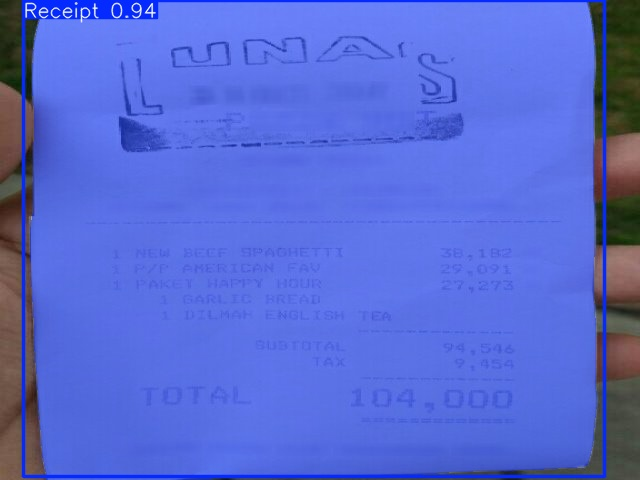

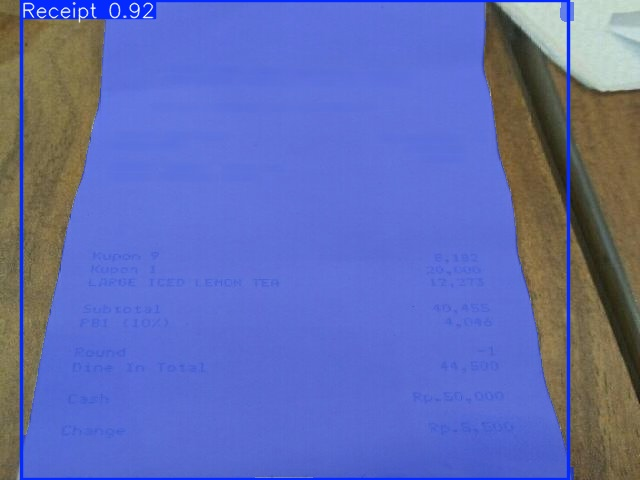

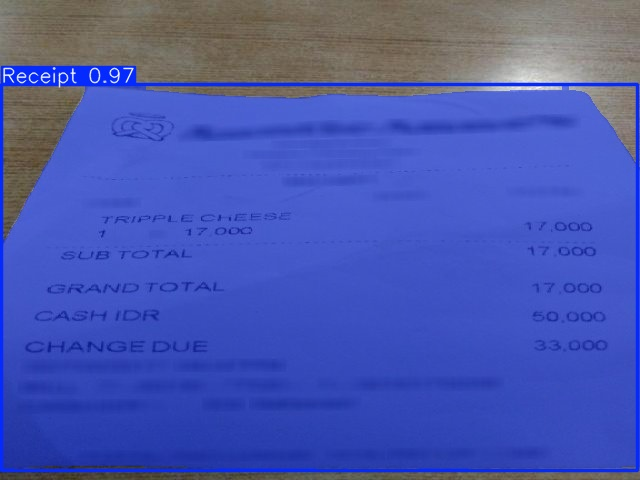

In [9]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/segment/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [12]:
!yolo task=segment mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 imgsz=640 source={HOME}/custom_data save=True

Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
YOLO11s-seg summary (fused): 113 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs

image 1/2 /workspace/custom_data/IMG_7593.jpg: 640x480 1 Receipt, 110.7ms
image 2/2 /workspace/custom_data/Receipt.jpeg: 640x384 1 Receipt, 90.4ms
Speed: 4.5ms preprocess, 100.5ms inference, 80.8ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/segment/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


### Use Segments from Yolo11 for further steps

In [148]:
p = os.listdir(f'{DATASET}/test/images')

img_name = p[1] 
img_path = f'{DATASET}/test/images/{img_name}' #f'{HOME}/custom_data/IMG_7593.jpg' 

In [149]:
from ultralytics import YOLO
model = YOLO(f'{HOME}/runs/segment/train/weights/best.pt')

result = model.predict(source=img_path, imgsz=640)


image 1/1 /workspace/receipt2json/datasets/receipt-instance-segmentation-2/test/images/12514370-receipt_00207_png_jpg.rf.ffc37f218510a99e596a0995cae08421.jpg: 480x640 1 Receipt, 17.8ms
Speed: 1.9ms preprocess, 17.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


In [150]:
!nvidia-smi --query-gpu=memory.free --format=csv

memory.free [MiB]
10731 MiB


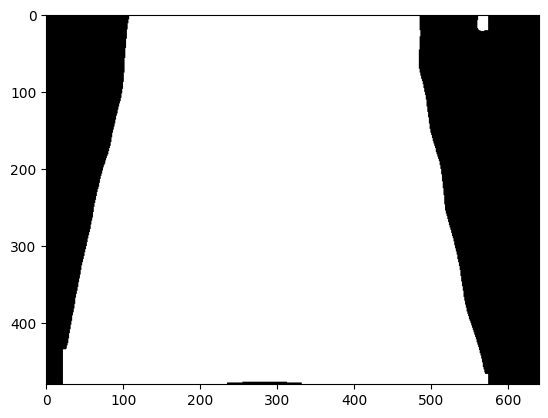

In [151]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

mask = result[0].masks.data[0].cpu().numpy().astype(np.uint8)*255

plt.imshow(mask, cmap="gray")

### Perform preprocessing on segmentation masks

In [198]:
def extend_segmentation_mask(mask, new_width, new_height):
    """
    Extends the original segmentation mask into a larger background.
    
    :param mask: The original segmentation mask (binary image).
    :param new_width: The desired width of the new image.
    :param new_height: The desired height of the new image.
    :return: A new mask placed in the center of a larger background.
    """
    # Create a new black background (larger image)
    extended_mask = np.zeros((new_height, new_width), dtype=np.uint8)

    # Get the top-left corner where the original mask will be placed
    top_left_x = (new_width - mask.shape[1]) // 2
    top_left_y = (new_height - mask.shape[0]) // 2

    # Place the original mask onto the extended background
    extended_mask[top_left_y:top_left_y + mask.shape[0], top_left_x:top_left_x + mask.shape[1]] = mask

    return extended_mask

def revert_corners_to_original(corner_coordinates, extended_mask_shape, original_mask_shape):
    """
    Reverts edges in the extended segmentation mask to fit the original image size.
    
    :param mask_extended: The extended segmentation mask (with background).
    :param original_mask_shape: The shape of the original mask (height, width).
    :return: Corner coordinates reverted back to original positions.
    """
    # Get the dimensions of the original mask
    original_height, original_width = original_mask_shape

    # Find the top-left corner of the original mask in the extended mask
    extended_height, extended_width = extended_mask_shape
    top_left_x = (extended_width - original_width) // 2
    top_left_y = (extended_height - original_height) // 2

    # Reconstruct x,y coordinates for corner points 
    crns_reconstructed = []
    crns = corner_coordinates.reshape(4,2)
    for crn in crns:
        x,y = crn
        x -= top_left_x
        y -= top_left_y
        crns_reconstructed.append([x,y])

    return np.array(crns_reconstructed)

In [153]:
# Extend the mask to fit the larger background
height, width = mask.shape
scaling = 1.1
new_height, new_width = scaling*height, scaling*width
mask_extended = extend_segmentation_mask(mask, int(new_width), int(new_height))

# Revert the extended mask to the original mask size
reverted_mask = revert_edges_to_original(mask_extended, (height, width))


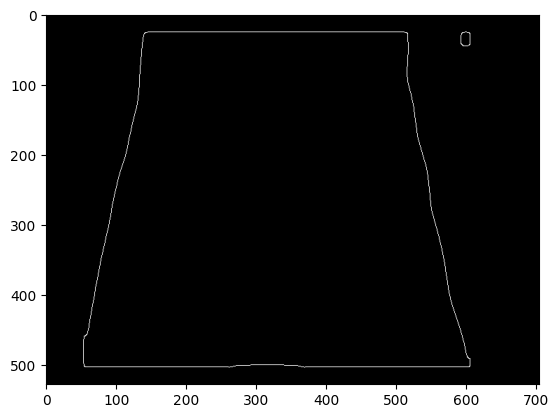

In [154]:
# Apply Gaussian blurring to reduce noise and apply edge detection
blurred = cv2.GaussianBlur(mask_extended, (11, 11), 0)
edge = cv2.Canny(blurred, 100, 200)

plt.imshow(edge, cmap="gray")

Note: you may need to restart the kernel to use updated packages.


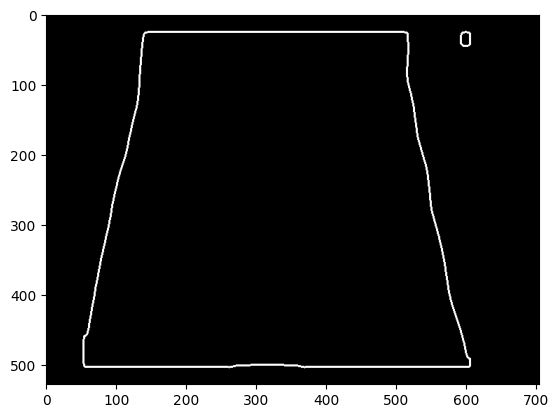

In [155]:
%pip install scikit-image
from skimage import morphology

dilated = cv2.dilate(edge, morphology.disk(1), iterations=1)

plt.imshow(dilated, cmap="gray")

In [203]:
img = cv2.imread(img_path)
height, width = result[0].masks.data[0].cpu().numpy().shape
img_resized = cv2.resize(img, (width, height))
img_resized_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

img_test = img_resized_rgb.copy()

def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)



In [184]:
# Find contours
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get largest contour 
largest_contour = sorted(contours, key = cv2.contourArea, reverse = True)[0]

#Fit the rotated rectangle
if contours:
    hull = cv2.convexHull(largest_contour)
    approx = approximate_contour(hull)
    rect = cv2.minAreaRect(hull)  # Get the rotated bounding box
    box = cv2.boxPoints(rect)  # Convert to 4 corner points
    box = np.int64(box)  # Convert to integer values

    # Draw the rectangle on the mask
    cv2.drawContours(img_test, [largest_contour], 0, (0, 255, 0), 2)
    cv2.drawContours(img_test, [hull], 0, (255, 0, 0), 2)
    cv2.drawContours(img_test, [approx], 0, (0, 0, 255), 2)



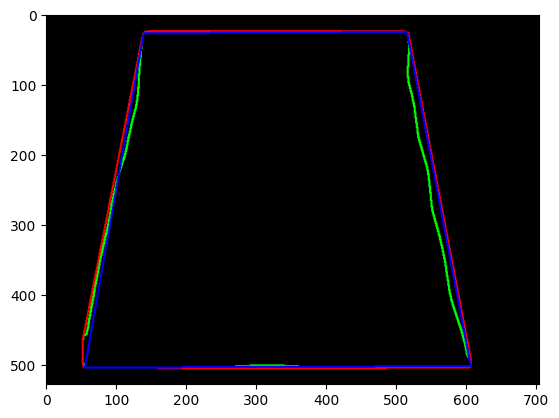

In [185]:
plt.imshow(img_test)

In [199]:
crns = revert_corners_to_original(approx, mask_extended.shape, mask.shape)

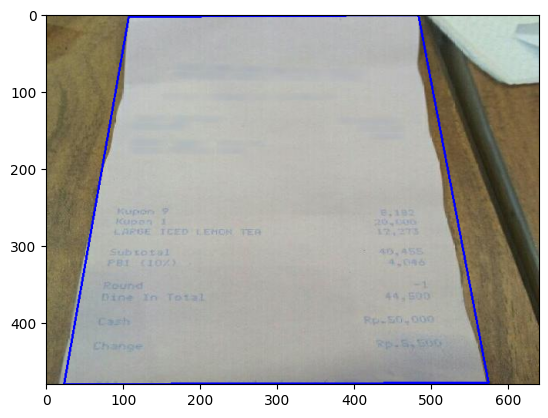

In [204]:
cv2.drawContours(img_test, [crns], 0, (0, 0, 255), 2)
plt.imshow(img_test)

In [240]:
def wrap_perspective(img, rect):
    # Unpack the rect points (in the order: tr, br, bl, tl)
    (tr, br, bl, tl) = rect
    
    # Correct the order of the points to: top-left, top-right, bottom-right, bottom-left
    rect = np.array([tl, tr, br, bl], dtype="float32")
    
    # Compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    
    # Compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    
    # Take the maximum of the width and height values to get the final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    
    # Define the destination points (ordered as: tl, tr, br, bl)
    dst = np.array([
        [0, 0],  # top-left
        [maxWidth - 1, 0],  # top-right
        [maxWidth - 1, maxHeight - 1],  # bottom-right
        [0, maxHeight - 1]  # bottom-left
    ], dtype="float32")
    
    # Calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    
    # Warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

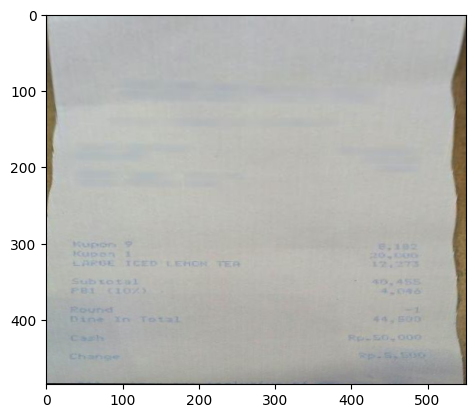

In [241]:
receipt = wrap_perspective(img_resized_rgb.copy(), crns)
plt.imshow(receipt)

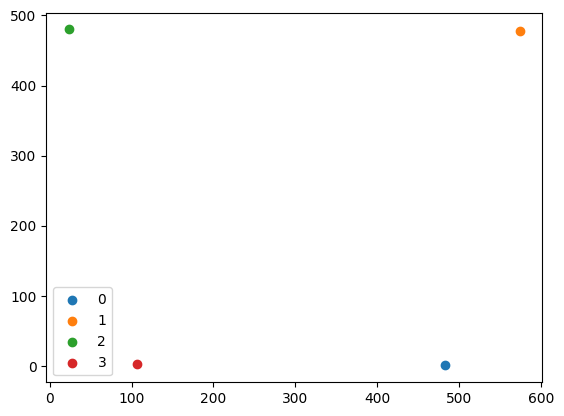

In [216]:
for i, (x,y) in enumerate(crns):
    plt.scatter(x,y, label=f"{i}")
plt.legend()

In [235]:
crns

array([[483,   1],
       [574, 478],
       [ 23, 480],
       [107,   3]], dtype=int32)